In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

import pandas as pd
import numpy as np
import os

In [2]:
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Bidirectional, TimeDistributed

from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
# read the dataset
df = pd.read_csv("ner.csv", encoding = "ISO-8859-1", error_bad_lines=False)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [4]:
df.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [5]:
len(df.columns)

25

In [6]:
df = df.drop([df.columns[0],df.columns[1],df.columns[2],df.columns[3],df.columns[4],df.columns[5],
             df.columns[6],df.columns[7],df.columns[8],df.columns[9],df.columns[10],
             df.columns[11],df.columns[12],df.columns[13],df.columns[14],df.columns[15],df.columns[16],
             df.columns[17],df.columns[18],df.columns[19],df.columns[20],df.columns[22]], axis='columns')

In [7]:
df.head()

,sentence_idx,word,tag
0,1.0,Thousands,O
1,1.0,of,O
2,1.0,demonstrators,O
3,1.0,have,O
4,1.0,marched,O


In [8]:
def prepare_word_tag_list(ser):
    sentence_list = []
    tag_list = []
    
    for i in range(len(ser)):
        sentence_list.append(ser.iloc[i,1])
        tag_list.append(ser.iloc[i,2])
    
    return sentence_list, tag_list

In [9]:
dataset = df.groupby(['sentence_idx']).apply(prepare_word_tag_list)

In [10]:
dataset.head()

sentence_idx
1.0    ([Thousands, of, demonstrators, have, marched,...
2.0    ([Families, of, soldiers, killed, in, the, con...
3.0    ([They, marched, from, the, Houses, of, Parlia...
4.0    ([Police, put, the, number, of, marchers, at, ...
5.0    ([The, protest, comes, on, the, eve, of, the, ...
dtype: object

In [11]:
dataset.shape

(35177,)

In [12]:
# get words
dataset.iloc[1547][0]

['More',
 'than',
 '160',
 'people',
 'have',
 'died',
 'from',
 'bird',
 'flu',
 'since',
 'late',
 '2003',
 '.',
 'More',
 'than',
 '160',
 'people',
 'have',
 'died',
 'from',
 'bird',
 'flu',
 'since',
 'late',
 '2003',
 '.']

In [13]:
# get tags
dataset.iloc[1547][1]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-tim',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-tim',
 'O']

In [14]:
for w in dataset:
    print(w[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']
['Families', 'of', 'soldiers', 'killed', 'in', 'the', 'conflict', 'joined', 'the', 'protesters', 'who', 'carried', 'banners', 'with', 'such', 'slogans', 'as', '"', 'Bush', 'Number', 'One', 'Terrorist', '"', 'and', '"', 'Stop', 'the', 'Bombings', '.', '"', 'Families', 'of', 'soldiers', 'killed', 'in', 'the', 'conflict', 'joined', 'the', 'protesters', 'who', 'carried', 'banners', 'with', 'such', 'slogans', 'as', '"', 'Bush', 'Number', 'One', 'Terrorist', '"', 'and', '"', 'Stop', 'the', 'Bombings', '.', '"']
['They', 'marched', 'from', 'the', 'Houses', 'of', '

['Egypt', 'has', 'the', 'largest', 'number', 'of', 'human', 'cases', 'of', 'bird', 'flu', 'outside', 'Asia', '.', 'Egypt', 'has', 'the', 'largest', 'number', 'of', 'human', 'cases', 'of', 'bird', 'flu', 'outside', 'Asia', '.']
['At', 'least', '13', 'people', 'have', 'died', 'since', 'the', 'first', 'confirmed', 'case', 'in', 'the', 'country', 'about', 'a', 'year', 'ago', '.', 'At', 'least', '13', 'people', 'have', 'died', 'since', 'the', 'first', 'confirmed', 'case', 'in', 'the', 'country', 'about', 'a', 'year', 'ago', '.']
['Thousands', 'of', 'people', 'in', 'the', 'Haitian', 'capital', 'have', 'demonstrated', 'in', 'support', 'of', 'presidential', 'candidate', 'Rene', 'Preval', '.', 'Thousands', 'of', 'people', 'in', 'the', 'Haitian', 'capital', 'have', 'demonstrated', 'in', 'support', 'of', 'presidential', 'candidate', 'Rene', 'Preval', '.']
['As', 'election', 'workers', 'continued', 'to', 'tally', 'votes', 'in', 'the', 'close', 'race', ',', 'demonstrators', 'gathered', 'outside', '

['The', 'high', 'cost', 'of', 'recovering', 'offshore', 'oil', 'and', 'gas', ',', 'combined', 'with', 'the', 'wide', 'swings', 'in', 'world', 'prices', 'for', 'oil', 'since', '1985', ',', 'has', 'led', 'to', 'fluctuations', 'in', 'new', 'drillings', '.', 'The', 'high', 'cost', 'of', 'recovering', 'offshore', 'oil', 'and', 'gas', ',', 'combined', 'with', 'the', 'wide', 'swings', 'in', 'world', 'prices', 'for', 'oil', 'since', '1985', ',', 'has', 'led', 'to', 'fluctuations', 'in', 'new', 'drillings', '.']
['The', 'Polynesian', 'Maori', 'reached', 'New', 'Zealand', 'in', 'about', 'A.D.', '800', '.', 'The', 'Polynesian', 'Maori', 'reached', 'New', 'Zealand', 'in', 'about', 'A.D.', '800', '.']
['In', '1840', ',', 'their', 'chieftains', 'entered', 'into', 'a', 'compact', 'with', 'Britain', ',', 'the', 'Treaty', 'of', 'Waitangi', ',', 'in', 'which', 'they', 'ceded', 'sovereignty', 'to', 'Queen', 'Victoria', 'while', 'retaining', 'territorial', 'rights', '.', 'In', '1840', ',', 'their', 'chief

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




['Officials', 'in', 'Caracas', 'say', 'the', 'proposed', 'deal', 'is', 'to', 'include', '10', 'C-295', 'transport', 'planes', ',', 'four', 'coastal', 'patrol', 'corvettes', ',', 'and', 'four', 'smaller', 'patrol', 'boats', '.']
['The', 'Associated', 'Press', 'quotes', 'Venezuelan', 'President', 'Hugo', 'Chavez', 'as', 'saying', 'the', 'patrol', 'boats', 'in', 'particular', 'will', 'help', 'in', 'the', 'fight', 'against', 'drug', 'trafficking', '.']
['On', 'Tuesday', ',', 'Mr.', 'Zapatero', ',', 'Mr.', 'Chavez', 'and', 'leaders', 'of', 'Brazil', 'and', 'Colombia', 'held', 'a', 'one-day', 'summit', 'in', 'Puerto', 'Ordaz', ',', 'Venezuela', 'to', 'discuss', 'trade', ',', 'political', 'alliances', 'and', 'terrorism', '.']
['The', 'economy', 'of', 'the', 'Democratic', 'Republic', 'of', 'the', 'Congo', '-', 'a', 'nation', 'endowed', 'with', 'vast', 'potential', 'wealth', '-', 'is', 'slowly', 'recovering', 'from', 'decades', 'of', 'decline', '.']
['Systemic', 'corruption', 'since', 'indepen

In [15]:
# unique words
words = set()
tags = set()

[words.add(elem) for d_elem in dataset for elem in np.unique(d_elem[0]) ];
words.add("ENDPAD")
words = list(words)

[tags.add(elem) for d_elem in dataset for elem in np.unique(d_elem[1]) ];
tags.add(np.nan)
tags = list(tags)

In [16]:
tags

['I-eve',
 nan,
 'B-geo',
 'I-geo',
 'I-org',
 'B-art',
 'O',
 'I-art',
 'B-nat',
 'B-per',
 'B-gpe',
 'B-tim',
 'I-per',
 'I-tim',
 'B-org',
 'I-nat',
 'I-gpe',
 'B-eve']

In [17]:
len(words)

30173

In [18]:
"ENDPAD" in words

True

In [19]:
word2idx = {words[i] : i for i in range(len(words))}
tag2idx = {tags[i] : i for i in range(len(tags))}

In [20]:
word2idx["ENDPAD"]

8917

In [21]:
tag2idx["O"]

6

In [22]:
tag2idx

{'I-eve': 0,
 nan: 1,
 'B-geo': 2,
 'I-geo': 3,
 'I-org': 4,
 'B-art': 5,
 'O': 6,
 'I-art': 7,
 'B-nat': 8,
 'B-per': 9,
 'B-gpe': 10,
 'B-tim': 11,
 'I-per': 12,
 'I-tim': 13,
 'B-org': 14,
 'I-nat': 15,
 'I-gpe': 16,
 'B-eve': 17}

In [23]:
# Convert sentence to numerical

X = [[word2idx[w] for w in elem[0]] for elem in dataset]
y = [[tag2idx[t] for t in elem[1]] for elem in dataset]

In [24]:
X = pad_sequences(maxlen=140, sequences=X, padding='post', value=word2idx["ENDPAD"])
y = pad_sequences(maxlen=140, sequences=y, padding='post', value=tag2idx["O"])

In [25]:
X.shape

(35177, 140)

In [26]:
y.shape

(35177, 140)

In [27]:
y[0]

array([ 6,  6,  6,  6,  6,  6,  2,  6,  6,  6,  6,  6,  2,  6,  6,  6,  6,
        6, 10,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  2,  6,  6,  6,
        6,  6,  2,  6,  6,  6,  6,  6, 10,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6])

In [28]:
# One-hot Encoding
y = to_categorical(y, num_classes=len(tag2idx))

In [29]:
y.shape

(35177, 140, 18)

In [30]:
# Train_Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [31]:
# Build Model
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input

input_node = Input(shape=(140,))
embedding = Embedding(input_dim=len(words), output_dim=100, input_length=140)(input_node)
rec_layer = Bidirectional(LSTM(50, return_sequences= True, recurrent_dropout=0.1))(embedding)
output = TimeDistributed(Dense(len(tag2idx), activation="softmax"))(rec_layer)

NER = Model(input_node, output)

In [32]:
NER.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [33]:
NER.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 100)          3017300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 100)          60400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 140, 18)           1818      
Total params: 3,079,518
Trainable params: 3,079,518
Non-trainable params: 0
_________________________________________________________________


In [34]:
history = NER.fit(X_train, np.array(y_train), batch_size=32, epochs=3, validation_split=0.2, verbose=1)

C:\Users\dtecitak\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 18854 samples, validate on 4714 samples
Epoch 1/3
18854/18854 [==============================] - 94s 5ms/step - loss: 0.1790 - accuracy: 0.9688 - val_loss: 0.0740 - val_accuracy: 0.9788
Epoch 2/3
18854/18854 [==============================] - 91s 5ms/step - loss: 0.0484 - accuracy: 0.9871 - val_loss: 0.0363 - val_accuracy: 0.9900
Epoch 3/3
18854/18854 [==============================] - 90s 5ms/step - loss: 0.0269 - accuracy: 0.9925 - val_loss: 0.0306 - val_accuracy: 0.9911


In [35]:
print(history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


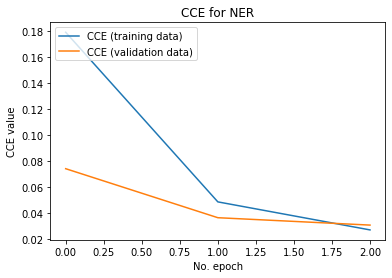

In [36]:
# Plot history: Categorical CrossEntropy(CCE)
plt.plot(history.history['loss'], label='CCE (training data)')
plt.plot(history.history['val_loss'], label='CCE (validation data)')

plt.title('CCE for NER')
plt.ylabel('CCE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()

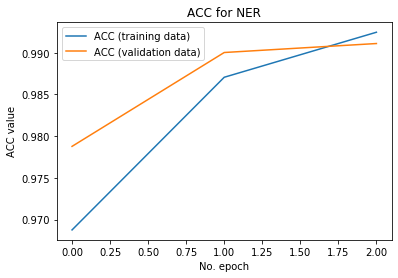

In [37]:
# Plot history: Accuracy(CCE)
plt.plot(history.history['accuracy'], label='ACC (training data)')
plt.plot(history.history['val_accuracy'], label='ACC (validation data)')

plt.title('ACC for NER')
plt.ylabel('ACC value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

plt.show()